### Image Classification with XResnet - [notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl2/11_train_imagenette.ipynb), [video](https://youtu.be/vnOpEwmtFJ8?t=1704)

Create an improved Resnet architecture from scratch, using some ideas from the Bag of Tricks paper. This is a 'real' CNN architecture for images, as opposed to the 'toy' CNN architectures used as a proof-of-concept for MNIST.

**Todos**
* first

**Done**
* first

### Import KD Libraries

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import IPython.core.debugger as db
from pathlib import Path
from functools import partial
import PIL, mimetypes
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, Sampler, SequentialSampler, RandomSampler

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
from nb_util import save_pickle, load_pickle, accuracy, DebugRand
from nb_data import DataBundle, FolderItemContainer, FileNameItemList, ImageFileItemList, ImageItemList, ClassNameItemList, ClassIdItemList
from nb_training import Trainer, Callback, CudaCB, ProgressCallback, AverageMetricsCB
from nb_optimiser import HyperParams, Recorder
from nb_arch import ArchBase
from nb_app import AppBase

### Define Data File Paths

In [6]:
#app_dir='imagen'
root_path = Path.cwd()
#data_path = root_path/app_dir
#data_path.mkdir(exist_ok=True)

g_root_path = Path(gd_path)/'data'

pickle_dir = root_path/'pickle'

### Download data

In [8]:
from fastai import datasets

IMAGENETTE_160_URL='https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'
path_imagenette = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path_imagenette, list(path_imagenette.iterdir()), list((path_imagenette/'val').iterdir())

(PosixPath('/root/.fastai/data/imagenette2-160'),
 [PosixPath('/root/.fastai/data/imagenette2-160/train'),
  PosixPath('/root/.fastai/data/imagenette2-160/val')],
 [PosixPath('/root/.fastai/data/imagenette2-160/val/n03888257'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n03000684'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n03394916'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n03425413'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n02102040'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n03028079'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n03417042'),
  PosixPath('/root/.fastai/data/imagenette2-160/val/n03445777')])

(245, 160, 3)


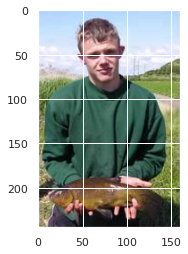

In [9]:
from matplotlib import pyplot as plt
import numpy
import PIL

path_tench = path_imagenette/'val'/'n01440764'
file_tench = list(path_tench.iterdir())[0]
img_tench = PIL.Image.open(file_tench)
npa_tench = numpy.array(img_tench)
print (npa_tench.shape)
plt.imshow(img_tench)

### XResnet Architecture Diagrams

Use these diagrams along with the explanation in the following section.

**Original Resnet**

Overview of the Resnet architecture (before XResnet improvements) shows the stages. The Input Stem is enlarged as well as the fourth stage. The Down-Sampling block within the fourth stage is enlarged, showing main Path A as well as the skip connection Path B.

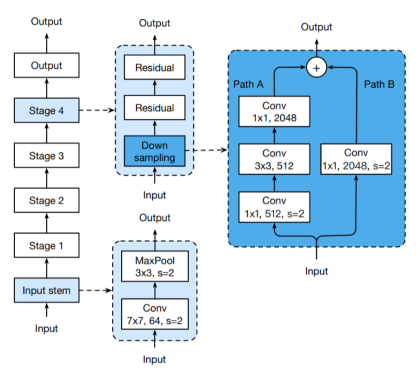

**Complete Resnet34 Architecture**

Detailed architecture of Resnet34, showing all layers. The Input Stem and Output are at the two ends and the coloured layers in the middle indicate the four stages. Each skip connection arrows indicate each Res Block. The dotted skip connection arrows indicate the Down-Sampling Res Blocks. The '/2' indicates a stride of 2, while everything else has a stride of 1.

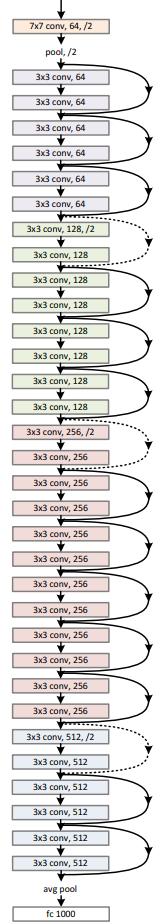

**Resnet Bottleneck**
Diagram on the left is a Standard Res Block used in the shallower Resnets (ie. resnet18 and resnet34). Diagram on the right is the Bottleneck Res Block used in the deeper Resnets.

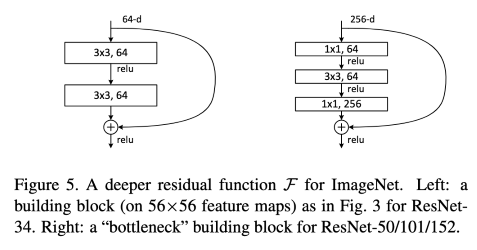

**Resnet Sizes**

This table shows the number and shapes of all the layers in the different Resnet versions. Each square bracket is a Res Block, and each row within it is a Conv Block. The multiplier next to the square brackets indicates the number of Res Blocks in that stage. Each Conv Block indicates the kernel size and the number of filter channels. 

We can see that the resnet18 and resnet34 use the Standard Res Block as their building block, with two Conv blocks. While the three deeper resnets use the Bottleneck Res Block with three Conv blocks.

'Conv1' in the first column is the Input Stem, and 'Conv2_x' through 'Conv5_x' are the four stages. As mentioned in the caption, the first Res Block of the 2nd, 3rd and 4th stages do Down-Sampling.

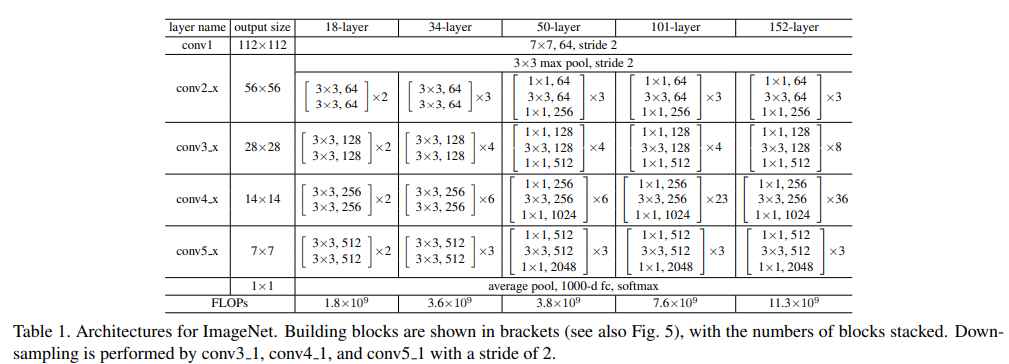

**XResnet Tweaks**

Diagrams for Resnet-B and Resnet-D show the design of the improved Down-Sampling blocks in XResnet. Diagram for Resnet-C shows the improved Input Stem.

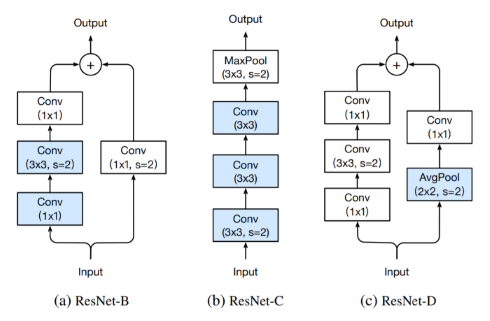

**XResnet Batch Norm**
This is the architecture of the Residual Skip Connection, where the identity input is added to the output of all the Conv Blocks (ie. the weight layers).

In XResnet, we do one trick with the BatchNorm initialization. We sometimes initialize the BatchNorm weights to be 0 and other times we initialize it to 1. Each ‘weight layer’ in the diagram is a Conv/BatchNorm. If the input to a ResBlock is x then its output is x+block(x). If we initialize the final BatchNorm layer in the block to 0, then this is the same as multiplying the input by 0, so block(x)=0. Therefore at the start of training all ResBlocks just return their inputs, and this mimics a network that has fewer layers and is easier to train at the initial stage.

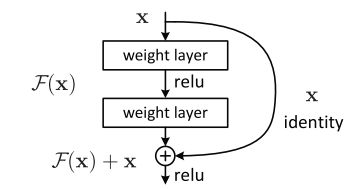

### Build Image Classification XResnet Architecture


Refer to the XResnet architecture diagrams above. The XResnet architecture is based on the [original](https://arxiv.org/pdf/1512.03385.pdf) Resnet architecture plus some improvements from the [Bag of Tricks](https://arxiv.org/pdf/1812.01187.pdf) paper. Also, some explanations in this [blog](https://jimypbr.github.io/2020/10/fast-ai-v3-lesson-12-notes-advanced-training-techniques-ulmfit-from-scratch).

In [ ]:
#----------------------------------------------------
# XResnet consists of these components arranged sequentially:
#  1) Input Stem
#  2) 4 Stages containing Residual Blocks
#  3) Output Layers
#
# There are five versions of the architecture, all of which have a similar structure, but with different depths.

# The original Input Stem consisted of a 7x7 Conv Block followed by a Max Pool. In XResnet, the Conv Block is replaced
# by three Conv Blocks.
#
# The 4 stages are very similar to each other. 
#   - Each stage contains several Residual Blocks. 
#   - Each Residual Block consists of some Conv Blocks along with a residual skip connection
#   - Each Conv Block consists of a Conv2D Layer along with a BatchNorm and Relu. The final Conv Block of all Residual Blocks
#         does not use a Relu.
#
# The Output Layer consists of an Avg Pool and Linear Layer.
#
# There are two types of Residual Blocks viz. the Standard block and the Bottleneck block. The two shallower 
# Resnets (Resnet18 and Resnet34) use the Standard blocks while the deeper Resnets (Resnet50, Resnet101 and Resnet152) 
# use the Bottleneck block.
#
# The Standard Residual block contains two Conv 3x3 blocks with skip connection.
# The Bottleneck Residual block contains three Conv blocks (1x1, 3x3, 1x1) with skip connection.
#
# All Standard and Residual blocks use a stride of 1 in all their Conv Blocks. Except for the first Residual block 
# of the 2nd, 3rd and 4th stages which has one Conv Block with a stride of 2 to reduce the dimensions of the image.
# This is known as a Down-Sampling block - it is essentially the same as the Standard or Bottleneck blocks except
# for one Conv Block with a stride of 2.
#
# The number of (depth) channels increases as you go from Stage 1 to Stage 4.
#
# Each Residual Block has two 'paths' - the regular Conv Block path and the skip connection path which is an 'identity'
# operation. However, since the skip connections get added to the output of the Conv Blocks, they do need to make 
# sure that their shapes are compatible viz. same image width/height and same number of channels.
#
# So, if the Conv Block path reduce the image size via a stride of 2, as in the Down Sampling block, the skip connection
# must do the same. Similarly, if the Conv Block path changes the number of channels, the skip connection must do
# the same. 

# In Resnet, the skip connection does both these things via a 1x1 Conv Block. It adjusts the channels with 
# the right number of filters, and uses a stride of 1 to keep the image width/height unchanged or a stride of 2 to
# reduce the image width/height.
#
# The XResnet modifies the design of the Down-Sampling block with two changes. It shifts the stride of 2 from
# the first Conv Block to the second. And for the skip connection, when a stride of 2 is required, it adds an 
# Avg Pool with a stride of 2.
#
# The XResnet also changes the initialisation of the Batch Norm weights inside the Conv Blocks. The Batch Norm
# associated with the final Conv Block in all Residual Blocks is initialised with zero weights. This ensures that
# the output coming out of the first path of the Residual Block is zero. Since this gets added to the identity
# coming out of the skip connection path, the output of the Residual Block is simply the identity ie. the output
# of that Block is the same as the input of that Block. This allows us to have very deep Resnets by making the
# initial training epochs stable with no exploding gradients.
#
# Use the diagram of the Table above as a reference. It shows the details of the number of Res Blocks in each of the resnet versions
# along with the sizes and channels of each Conv Block. As we can see:
#  1) resnet18/resnet34 use the Standard Res block. All Conv blocks inside all Res blocks within a stage use the same number of channels. 
#     Then the channels are doubled for the next stage. This means that the first Res blocks in each stage have to take care of doubling 
#     the channel filters in the main path and in the skip connection path.
#
#  2) resnet50/resnet101/resnet152 use the Bottleneck block. All Conv blocks inside all Res blocks within a stage use the same number 
#     of channels, except for the final Conv block in each Res block, which uses 4x channels. Then the channels are doubled for the next 
#     stage. This means that the first and last Conv blocks in each Res block have to take care of stepping up or stepping down the
#     channel filters in the main path and in the skip connection path. eg. Second stage in Resnet50 has channels in its four Res
#     blocks as below:
#       --> incoming from first stage (256) --> (128, 128, 512) --> (128, 128, 512) --> (128, 128, 512) --> (128, 128, 512) --> outgoing to third stage (512)
#----------------------------------------------------

In [10]:
# ----------------------------
# Identity function used in the skip connections
# ----------------------------
def noop(x): return x

# ----------------------------
# Flatten the outputs from the Residual Block stages before feeding to the Output
# Layers at the end of the Resnet.
# ----------------------------
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

# ----------------------------
# Create the components of a Conv Block - Conv layer, Batch Norm and Relu
# ----------------------------
def conv_block(c_in, c_out, kernel_size, stride, bias=False, init_bn_zero=False, is_relu=True):
  # Conv 2D layer
  conv = nn.Conv2d(c_in, c_out, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=bias)

  # Batch Norm layer. Its weights are usually initialised to 1, except when we use the Batch Norm
  # trick and initialise the weights to 0.
  bn = nn.BatchNorm2d(c_out)
  nn.init.constant_(bn.weight, 0. if init_bn_zero else 1.)
  
  # Add a Relu if required and wrap up the block in a Sequential
  if (is_relu):
    relu = nn.ReLU(inplace=True)
    return nn.Sequential(conv, bn, relu)
  else:
    return nn.Sequential(conv, bn)

# ----------------------------
# Create the components of a Res Block viz. its Conv Blocks and the Skip Connection.
# The Res Block is of type Standard or Bottleneck. In addition, it has a Down-Sample flag.
# 'c_block_in' is the input channels to the Res Block and 'c_block_out' is the output
# channels from the Res Block.
#
# The skip connection is performed using two operations - an 'idconv' to match the
# number of channels and a 'pool' to match the image width/height.
# ----------------------------
class ResBlock(nn.Module):
  def __init__(self, block_type, down_sample, c_block_in, c_block_out):
    assert (block_type in ['standard', 'bottle_neck'])
    super().__init__()

    # Stride is 2 if this is a Down-Sample block, otherwise it is 1.
    sample_stride = 2 if down_sample else 1

    if (block_type == 'standard'):
      # Create a Standard Res Block with two Conv Blocks. If it is a Down-Sample, then the
      # first Conv Block has a stride of 2. The last Conv Block uses the Batch Norm weight
      # trick and has no Relu. 

      conv1 = conv_block(c_block_in, c_block_out, kernel_size=3, stride=sample_stride)
      conv2 = conv_block(c_block_out, c_block_out, kernel_size=3, stride=1, init_bn_zero=True, is_relu=False)
      self.convs = nn.Sequential(conv1, conv2)

    elif (block_type in ['bottle_neck']):
      # Create a Bottleneck Res Block with three Conv Blocks. If it is a Down-Sample, then the
      # second Conv Block has a stride of 2. The last Conv Block uses the Batch Norm weight
      # trick and has no Relu.

      # The third Conv block outputs 4x times the channels of the second and third Conv blocks.
      c_conv = c_block_out // 4
      conv1 = conv_block(c_block_in, c_conv, kernel_size=1, stride=1)
      conv2 = conv_block(c_conv, c_conv, kernel_size=3, stride=sample_stride)
      conv3 = conv_block(c_conv, c_block_out, kernel_size=1, stride=1, init_bn_zero=True, is_relu=False)
      self.convs = nn.Sequential(conv1, conv2, conv3)

    # Skip Connection - match the channels
    if (c_block_in == c_block_out):
      # If the input and output channels are the same, then use the identity.
      self.idconv = noop
    else:
      # If the channels are different, then use a 1x1 Conv to adjust the channels
      self.idconv = conv_block(c_block_in, c_block_out, kernel_size=1, stride=1, is_relu=False)

    # Skip Connection - match the image width/height
    if down_sample:
      # Image width/height changes only for Down-Sample blocks, since it uses a stride of 2.
      # So the skip connection uses an Avg Pool to adjust the image size.
      self.pool = nn.AvgPool2d(2, ceil_mode=True)
    else:
      # All other blocks use a stride of 1, with no change to image size. So use the
      # identity.
      self.pool = noop

  # ----------------------------
  # Add the result of the Conv blocks from the main path to the Skip Connection
  # path. As above, the final Conv block has no Relu - we perform the Relu below after 
  # adding the skip connection.
  # ----------------------------
  def forward(self, x):
    res_x = self.convs(x) + self.idconv(self.pool(x))
    relu_x = F.relu(res_x)
    return relu_x

#----------------------------------------------------
# XResnet architecture. It consists of these modules:
#----------------------------------------------------
class XResNet(nn.Module):
  # ----------------------------
  # Create the main building blocks of the XResnet
  # ----------------------------
  def __init__(self, num_blocks_list, block_type, c_stages, c_in=3, c_out=1000):
    assert (block_type in ['standard', 'bottle_neck'])
    super().__init__()

    # Build the Input Stem
    stem = self._input_stem(c_in)

    # Build the four Stages
    # The first Stage has no Down-Sample block, while the second, third and fourth Stages have it.
    stages = [None] * 4
    stages[0] = self._build_stage(num_blocks_list[0], block_type, False, c_stages[0], c_stages[1])
    stages[1] = self._build_stage(num_blocks_list[1], block_type, True, c_stages[1], c_stages[2])
    stages[2] = self._build_stage(num_blocks_list[2], block_type, True, c_stages[2], c_stages[3])
    stages[3] = self._build_stage(num_blocks_list[3], block_type, True, c_stages[3], c_stages[4])

    out = self._build_output(c_stages[-1], c_out)

    self.net = nn.Sequential(
      *stem,
      *stages,
      *out
    )
    self._init_wgts(self.net)

  # ----------------------------
  # Straightforward computation as Resnet is just a Sequential
  # ----------------------------
  def forward(self, x):
    return self.net(x)

  # ----------------------------
  # Build the Input Stem
  # ----------------------------
  def _input_stem(self, c_in):
    stem = [None] * 4
    stem[0] = conv_block(c_in, (c_in+1)*8, kernel_size=3, stride=2)
    stem[1] = conv_block((c_in+1)*8, 64, kernel_size=3, stride=1)
    stem[2] = conv_block(64, 64, kernel_size=3, stride=1)
    stem[3] = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    return stem

  # ----------------------------
  # Build the Output Layers
  # ----------------------------
  def _build_output(self, c_last_stage_out, c_out):
    out = [
      nn.AdaptiveAvgPool2d(1), 
      Flatten(),
      nn.Linear(c_last_stage_out, c_out)
    ]
    return out

  # ----------------------------
  # Build a Stage as a sequence of Res Blocks
  #   1) 'num_blocks' - number of Res Blocks in the Stage
  #   2) 'first_block_down_sample' - flag indicating whether the Stage has a Down-Sample block. It is 
  #      False for the first Stage and True for the second, third and fourth Stages.
  #   3) 'c_stage_in' is the input channels to the Stage and 'c_stage_out' is the output channels from 
  #      the Stage.
  # ----------------------------
  def _build_stage(self, num_blocks, block_type, first_block_down_sample, c_stage_in, c_stage_out):
    # Build all the Res Blocks within the Stage. If the Stage has a Down-Sample block, then the first Res
    # Block within that Stage becomes a Down-Sample block.
    # The number of input channels to the Stage get passed to the first Res block. The output channels from
    # that Res Block get passed as input to the next Res block and so on. The number of output channels for 
    # all Res Blocks in the Stage are the same. 
    blocks = [ResBlock(block_type, first_block_down_sample if i==0 else False, c_stage_in if i==0 else c_stage_out, c_stage_out) for i in range(num_blocks)]
    stage = nn.Sequential(*blocks)
    return stage

  # ----------------------------
  # Initialise weights and biases for the whole Resnet.
  # ----------------------------
  def _init_wgts(self, m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): self._init_wgts(l)

#----------------------------------------------------
# Convenience functions for all the Resnet versions. Each indicates the number of Res Blocks in
# each of the four stages, whether it uses a Standard or Bottleneck Res block and the number of
# channels used by each stage.
#----------------------------------------------------
def xresnet18 (**kwargs): return XResNet([2, 2,  2, 2], 'standard', [64, 64, 128, 256, 512], **kwargs)
def xresnet34 (**kwargs): return XResNet([3, 4,  6, 3], 'standard', [64, 64, 128, 256, 512], **kwargs)
def xresnet50 (**kwargs): return XResNet([3, 4,  6, 3], 'bottle_neck', [64, 256, 512, 1024, 2048], **kwargs)
def xresnet101(**kwargs): return XResNet([3, 4, 23, 3], 'bottle_neck', [64, 256, 512, 1024, 2048], **kwargs)
def xresnet152(**kwargs): return XResNet([3, 8, 36, 3], 'bottle_neck', [64, 256, 512, 1024, 2048], **kwargs)

In [18]:
#----------------------------------------------------
# Create the Image Classification XResnet architecture
#----------------------------------------------------
class ArchImageClassification(ArchBase):
  # ----------------------------
  # Create the XResnet model
  # ----------------------------
  def create_model(self):
    model_fn = partial(xresnet34, c_out=10)
    self.model = model_fn()

  def module_groups(self):
    pass

  def hook_groups(self):
    pass

### Define Image Classification Data Bundle

In [12]:
#----------------------------------------------------
# Image Classification data preparation pipeline
#----------------------------------------------------
class ImageClassificationDataBundle(DataBundle):
  def __init__(self, folder_path):
    print ('--------- Image Classification DataBundle init', folder_path)

    # Get list of image file extensions
    # Load all files with image extensions from the given folder path
    # Split based on training and validation sub-folders in the top-level folder path
    # Loaded files can be directly used as 'x' items, no extraction necessary
    # Use the parent folder name of each file as the class name for the 'y' labels. Done through a custom extraction function.
    # Convert the 'x' items from Image Files to Images
    # Convert the 'y' items from Class Names to Class Ids
    # At runtime, dynamically read an Image and apply some image processing steps. Finally
    # convert to tensors of floats

    image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))
    ' '.join(image_extensions)
    load_params = {'source': FolderItemContainer, 'target_cls': ImageFileItemList, 'folder_path': folder_path, 'extensions': image_extensions}
    split_params = {'split_procedure': 'split_path', 'train_folder': 'train', 'valid_folder': 'val'}
    extract_x_params = {'extract_procedure': None, 'target_cls': None}
    y_custom_fn=partial(FileNameItemList.get_ancestor, up_level=1)
    extract_y_params = {'extract_procedure': 'extract_custom', 'target_cls': ClassNameItemList, 'custom_fn': y_custom_fn}
    convert_x_params = [
        {'target_cls': ImageItemList, 'convert_procedure': 'FileToImage'}, 
    ]
    convert_y_params = [
        {'target_cls': ClassIdItemList, 'convert_procedure': 'NameToId'} 
    ]
    xform_x_params = [
        {'xform_procedure': 'make_rgb'}, 
        {'xform_procedure': 'resize', 'size': 128},
        {'xform_procedure': 'to_byte_tensor'},        
        {'xform_procedure': 'to_float_tensor'},
        {'xform_procedure': 'normalise'},
        # Example only {'xform_procedure': 'Custom', 'custom_fn': func}        
    ]
    # These dl_params are not really required for this DataBundle. They are there as test cases for different param combinations
    dl_params = (
        {'bs': 64, 'sampler_fn': RandomSampler},     # for training
        {'bs': 64, 'sampler_fn': SequentialSampler}  # for valid/test
    )
    self.post_proc_params = [
        {'proc_procedure': 'set_mean_std', 'mean': [0.5, 0.5, 0.5], 'std':[0.5, 0.5, 0.5]}, 
    ]
    self.display_params = {
        'layout_procedure': 'display_images', 'figsize': (20, 5),
        'xyz_procedures': ('image', 'label', 'label')
    }
    super().__init__(load_params, split_params, extract_x_params, extract_y_params, convert_x_params, convert_y_params, xform_x_params=xform_x_params, dl_params=dl_params)

### Define Image Classification application class 

In [13]:
#----------------------------------------------------
# Image Classification Application
#----------------------------------------------------
class AppImageClassification(AppBase):

  def __init__(self):
    super().__init__(loss_type='multi_classif', metrics_cbs=[AverageMetricsCB(accuracy)])
    self.class_vocab_i2n = None

    self.debug_cbs = []
    self.dtr = None
    self.hooks = None
 
  #----------------------------------------------------
  # Load the data using the Image Classification Data Bundle
  #----------------------------------------------------
  def load_data(self, file_path):
    self.db = ImageClassificationDataBundle(file_path)
    self.db.process()
    self.class_vocab_i2n = self.db.train_ds.y.class_vocab_i2n

  #----------------------------------------------------
  # Create the architecture
  #----------------------------------------------------
  def create_arch(self):
    self._arch = ArchImageClassification()
    self._arch.create_model()
    return self._arch

  #----------------------------------------------------
  # Train the model
  #----------------------------------------------------
  def run_train(self, num_epochs=1, split_lr=[1e-3], weight_decay=0.2, one_cycle=False):
    assert(isinstance(one_cycle, bool))

    train_dl = self.db.train_dl
    valid_dl = self.db.valid_dl

    # Loss function
    loss_func = self.loss_fn

    # Model
    arch = self._arch
    model = arch.model

    opt_adamw = partial(optim.AdamW, betas=(0.9, 0.99), weight_decay=weight_decay)
    lr_sched='one_cycle' if one_cycle else None
    opt, hyper_cbs = HyperParams.set(model, module_groups=None, split_lr=split_lr, split=False, lr_sched=lr_sched, opt_func=opt_adamw)

    gpu_cbs = [CudaCB(device = torch.device('cuda',0))]
    track_cbs = [Recorder(), ProgressCallback()]
    callbs = gpu_cbs + track_cbs
    callbs += self.metrics_cbs + hyper_cbs + self.debug_cbs

    loop = Trainer(train_dl, valid_dl, model, opt, loss_func, callbs, dtr=self.dtr)
    loop.hooks = self.hooks

    loop.fit(num_epochs=num_epochs)
    return loop

  #----------------------------------------------------
  # Train the model
  #----------------------------------------------------
  def run_predict(self):
    valid_dl = self.db.valid_dl
    self._arch.model.eval()
    device = list(self._arch.model.parameters())[0].device

    inps, outs, targs = [], [], []
    with torch.no_grad():
      for _, (xb, yb) in enumerate(valid_dl):
        xb = xb.to(device)
        yhat = self._arch.model(xb)
        pred = yhat.argmax(dim=1)
        for x, y, p in zip (xb, yb, pred):
          inp = [w for w in x]
          inps.append(inp)
          out = [w for w in p]
          outs.append(out)
          targ = [w for w in y]
          targs.append(targ)
    return inps, outs, targs

### Load data and run model

In [14]:
load_full = True
if (load_full):
  load_imgs_path = path_imagenette
  load_bs = 64
else:
  load_imgs_path = None
  load_bs = 6

In [19]:
ic_app = AppImageClassification()
ic_app.load_data(load_imgs_path)
save_pickle(ic_app, pickle_dir, 'proc_data.pkl')

--------- Image Classification DataBundle init /root/.fastai/data/imagenette2-160
FolderItemContainer loaded 13394 items of type ImageFileItemList
Split using split_path into 9469, 3925 and 0 items of type ImageFileItemList
No extraction
Extracted 9469 items of type ClassNameItemList using extract_custom
Converted 9469 items to type ImageItemList using FileToImage
Converted 9469 items to type ClassIdItemList using NameToId
No extraction
Extracted 3925 items of type ClassNameItemList using extract_custom
Converted 3925 items to type ImageItemList using FileToImage
Converted 3925 items to type ClassIdItemList using NameToId
Final ImageItemList (9469 items)
[PosixPath('/root/.fastai/data/imagenette2-160/train/n03888257/n03888257_41069.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03888257/n03888257_27975.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03888257/n03888257_59397.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03888257/n03888257_7474.J

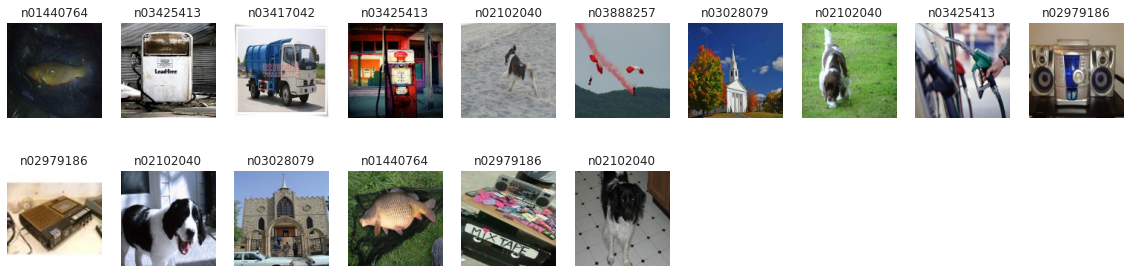

In [15]:
ic_app.db.display_batch()

In [27]:
DebugRand.set_seed(0)
ic_app = load_pickle(pickle_dir/'proc_data.pkl')

ic_app.create_arch()
ic_app._arch.save_weights(pickle_dir/'arch_init_wgts.mdl')
ic_app._arch.load_weights(pickle_dir/'arch_init_wgts.mdl')

ic_app.create_debug(use_dtr=True, track_batches_per_epoch=10, disp_tb=False, disp_pd=True, debug_bkwd=False, debug_fwd=False, abort_iter=0)

In [21]:
find_lr = True
if (find_lr):
  loop = ic_app.lr_find(start_lr=1e-7, end_lr=10, num_iter=100)

In [28]:
loop = ic_app.run_train(num_epochs=5, split_lr=[1e-2], weight_decay=0.01, one_cycle=True)

epoch,tr_loss,smooth_loss,val_loss,accuracy,time
0,1.613862,1.490979,1.633077,0.497834,00:47
1,1.212253,1.161139,1.651006,0.488917,00:47
2,0.895358,0.880142,1.190632,0.622675,00:47
3,0.624558,0.607970,0.713347,0.763057,00:47
4,0.383108,0.371337,0.570637,0.814777,00:47


In [ ]:
# Be careful about running this. Do it only when we get results that are better
# than the already saved model
#torch.save(trt_app._arch.model.state_dict(), data_path/'arch_init_wgts.mdl')

(None, None)

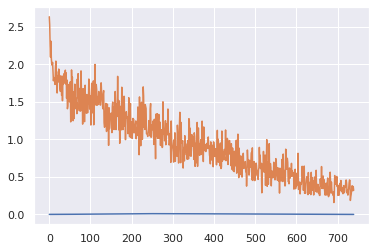

In [31]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [29]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df
is_batch_df.head(2)
is_layer_df.head(2)

,run_id,num_epochs,row_type,epoch_id,num_tr_batches,num_val_batches,tr_loss,smooth_loss,val_loss,accuracy,time
0,Run-20201120_060110,5.0,run,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Run-20201120_060110,NaN,epoch,0.0,148.0,62.0,1.613862,1.490979,1.633077,0.497834,00:47
22,Run-20201120_060110,NaN,epoch,1.0,148.0,62.0,1.212253,1.161139,1.651006,0.488917,00:47
43,Run-20201120_060110,NaN,epoch,2.0,148.0,62.0,0.895358,0.880142,1.190632,0.622675,00:47
64,Run-20201120_060110,NaN,epoch,3.0,148.0,62.0,0.624558,0.607970,0.713347,0.763057,00:47
85,Run-20201120_060110,NaN,epoch,4.0,148.0,62.0,0.383108,0.371337,0.570637,0.814777,00:47


,run_id,row_type,epoch_id,batch_id,iter,batch_type,pred,loss,lr,mom,betas_2,eps,weight_decay,amsgrad
2,Run-20201120_060110,batch,0.0,0-0,0.0,train,0.033061,2.633710,0.0004,0.950000,0.99,1.000000e-08,0.01,False
3,Run-20201120_060110,batch,0.0,0-1,1.0,train,0.045757,2.525733,0.0004,0.949995,0.99,1.000000e-08,0.01,False


""


In [ ]:
display_metrics(is_batch_df)

In [ ]:
!rm -r tbtry

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir tbtry

In [ ]:
## Save last good run
## Compare with last good run

In [ ]:
inps, outs, targs = trt_app.run_predict()
#inps[4], outs[4], targs[4]
# !!!!! To use display_results, run_predict() should return raw word_ids, not strings
trt_app.db.display_results(inps, targs, outs)